In [1]:
######## Packages ########
import numpy as np 
from scipy import stats
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML 

## 4.3.3
ポアソン混合モデルに対する変分推論アルゴリズムを実装する．
- 参考
    - https://www.anarchive-beta.com/entry/2020/04/23/171354

ここでは，4.3.2と同様に，2つのポアソン分布を混合することによって得られた2峰性の1次元データに対してギブスサンプリングを適用する．

In [2]:
#################### param (truth) ####################
lambda_truth = np.array([5, 25])
pi_truth = np.array([0.3, 0.7])
#######################################################

In [3]:
#################### Param (observed) ####################
N = 100                 # the number of observed data
K = len(lambda_truth)   # the number of clusters
##########################################################


#################### Clusters (Eq.(4.2)) ####################
s_nk = stats.multinomial(n=1, p=pi_truth).rvs(size=N)
#############################################################


#################### Observed data (Eq.(4.28)) ####################
def generate_observed_data(lmd, s, K):
    dt = 1
    for k in range(K):
        val = stats.poisson(mu = lmd[k]).rvs()
        dt = dt*val**s[k]
    return dt

x_n = []
for n in range(N):
    x_n.append(generate_observed_data(lmd=lambda_truth, s=s_nk[n], K=K))
x_n = np.array(x_n)
###################################################################

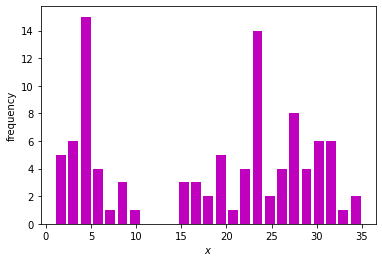

In [4]:
#################### Plot observed data ####################
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$x$"); ax.set_ylabel("frequency")
ax.hist(x_n, bins=25, rwidth=0.8, color='m')
plt.show()
############################################################

In [5]:
#################### Param (estimation) ####################
maxiter = 50                # the number of iteration
a = 1; b = 1                # hyper parameter for gamma distribution
alpha = np.array([2, 2])  # hyper parameter for Dirichlet distribution
############################################################

#################### Generate initial value ####################
E_lambda_init = stats.uniform().rvs(size=K)
E_ln_lambda_init = np.log(E_lambda_init)
E_pi_init_0 = stats.uniform().rvs()
E_pi_init = np.array([E_pi_init_0, 1 - E_pi_init_0])
E_ln_pi_init = np.log(E_pi_init)
################################################################

In [6]:
#################### list ####################
def make_list(n):
    return [[] for i in range(n)]
##############################################


#################### update eta (Eq.(4.51)) ####################
def update_eta(x, E_lambda, E_ln_lambda, E_ln_pi):
    eta = []
    for n in range(len(x)):
        eta_tmp = []
        for k in range(len(E_lambda)):
            eta_tmp.append(np.exp(x[n]*E_ln_lambda[k] - E_lambda[k] + E_ln_lambda[k]))
        eta_n = np.array(eta_tmp) / sum(eta_tmp)    # normalization
        eta.append(eta_n)
    return np.array(eta)
################################################################


#################### update a and b (Eq.(4.55)) ####################
def update_a_b(x, eta, a, b):
    hat_a = []; hat_b = []
    for k in range(len(eta.T)):
        hat_a.append(np.sum(eta.T[k] * x) + a)
        hat_b.append(np.sum(eta.T[k]) + b)
    hat_a = np.array(hat_a); hat_b = np.array(hat_b)
    return hat_a, hat_b 
####################################################################


#################### update pi (Eq.(4.58)) ####################
def update_pi(eta, alpha):
    hat_alpha = []
    for k in range(len(alpha)):
        hat_alpha.append(np.sum(eta.T[k]) + alpha[k])
    hat_alpha = np.array(hat_alpha)
    return hat_alpha
###############################################################


#################### update expected value (Eq.(4.60) -- (4.62)) ####################
def update_expected(hat_a, hat_b, hat_alpha):
    E_lambda = []; E_ln_lambda = []; E_ln_pi = []
    for k in range(len(hat_a)):
        ###### update E[lambda] (Eq.(4.60)) ######
        E_lambda.append(hat_a[k]/hat_b[k])
        ##########################################

        ###### update E[ln lambda] (Eq.(4.61)) ######
        E_ln_lambda_k = special.psi(hat_a[k]) - np.log(hat_b[k])
        E_ln_lambda.append(E_ln_lambda_k)
        #############################################

        ###### update E[ln pi] (Eq.(4.62)) ######
        E_ln_pi_k = special.psi(hat_alpha[k]) - special.psi(np.sum(hat_alpha))
        E_ln_pi.append(E_ln_pi_k)
        #########################################
    E_lambda = np.array(E_lambda); E_ln_lambda = np.array(E_ln_lambda); E_ln_pi = np.array(E_ln_pi)
    return E_lambda, E_ln_lambda, E_ln_pi
######################################################################################

In [7]:
#################### Variational inference ####################
def variational_inference_poisson(maxiter, N, K, E_lambda_init, E_ln_lambda_init, E_ln_pi_init, x, a, b, alpha):
    #################### Initialization ####################
    E_lambda_list = []; E_ln_lambda_list = []; E_ln_pi_list = []
    Eta_list = []; hat_a_list = []; hat_b_list = []; hat_alpha_list = []
    ########################################################

    #################### Loop process ####################
    for i in range(maxiter):
        if i == 0:
            E_lambda = E_lambda_init; E_ln_lambda = E_ln_lambda_init; E_ln_pi = E_ln_pi_init
        else:
            E_lambda = E_lambda_list[-1]; E_ln_lambda = E_ln_lambda_list[-1]; E_ln_pi = E_ln_pi_list[-1]
        #################### s_n (Eq.(4.50)) ####################
        eta = update_eta(x=x_n, E_lambda=E_lambda, E_ln_lambda=E_ln_lambda, E_ln_pi=E_ln_pi)
        Eta_list.append(eta)
        #########################################################

        #################### lambda_k (Eq.(4.54)) ####################
        hat_a, hat_b = update_a_b(x=x_n, eta=eta, a=a, b=b)
        hat_a_list.append(hat_a); hat_b_list.append(hat_b)
        ##############################################################

        #################### pi (Eq.(4.57)) ####################
        hat_alpha = update_pi(eta=eta, alpha=alpha)
        hat_alpha_list.append(hat_alpha)
        ########################################################

        #################### expected value ####################
        E_lambda_new, E_ln_lambda_new, E_ln_pi_new = update_expected(hat_a=hat_a, hat_b=hat_b, hat_alpha=hat_alpha)
        E_lambda_list.append(E_lambda_new); E_ln_lambda_list.append(E_ln_lambda_new); E_ln_pi_list.append(E_ln_pi_new)
        ########################################################
    #########################################################

    E_lambda_list = np.array(E_lambda_list); E_ln_lambda_list = np.array(E_ln_lambda_list); E_ln_pi_list = np.array(E_ln_pi_list)
    Eta_list = np.array(Eta_list); hat_a_list = np.array(hat_a_list); hat_b_list = np.array(hat_b_list); hat_alpha_list = np.array(hat_alpha_list)
    return hat_a_list, hat_b_list, hat_alpha_list
##############################################################

In [8]:
#################### execute variational inference ####################
hat_a_inference, hat_b_inference, hat_alpha_inference = variational_inference_poisson(maxiter=maxiter, N=N, K=K, E_lambda_init=E_lambda_init, E_ln_lambda_init=E_ln_lambda_init, E_ln_pi_init=E_ln_pi_init, x=x_n, a=a, b=b, alpha=alpha)
#######################################################################

MovieWriter imagemagick unavailable; using Pillow instead.


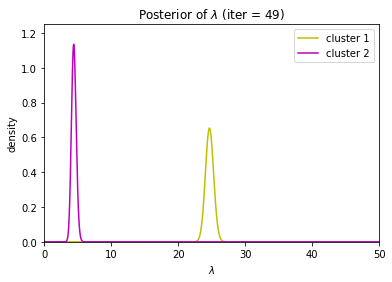

In [9]:
# post 
z1 = np.linspace(0, 50, 5001)
## lambda
lambda_pdf_post = make_list(K)
for i in range(maxiter):
    for k in range(K):
        cluster_k = stats.gamma(a=hat_a_inference[i][k], scale=1/hat_b_inference[i][k]).pdf(z1)
        lambda_pdf_post[k].append(cluster_k)

### plot lambda
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def update_lambda(frame):
    ax.clear()
    ax.set_xlabel(r"$\lambda$"); ax.set_ylabel("density")
    ax.set_title("Posterior of " + r"$\lambda$ " + "(iter = {})".format(frame))
    ax.set_xlim([0, 50]); ax.set_ylim([0, 1.25])
    #### plot pdf ####
    color_list = ["y", "m"]
    for k in range(K):
        ax.plot(z1, lambda_pdf_post[k][frame], color=color_list[k], label="cluster {}".format(k + 1))
    ax.legend(loc="upper right")

ani = animation.FuncAnimation(fig, update_lambda, frames=range(1, maxiter), interval=200)
ani.save("4.3.3_posteior_lambda.gif", writer="imagemagick")
HTML(ani.to_jshtml())

MovieWriter imagemagick unavailable; using Pillow instead.


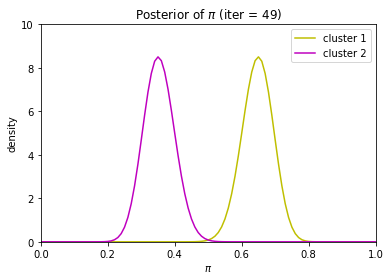

In [10]:
## pi (Dir -> beta)
z2 = np.linspace(0, 1, 101)
pi_post = make_list(K); K_list = list(range(K))
for i in range(maxiter):
    for k in K_list:
        key = list(set(K_list) - {k})[0]
        pi = stats.beta(a=hat_alpha_inference[i][k], b=hat_alpha_inference[i][key]).pdf(z2)
        pi_post[k].append(pi)

### post pi
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def update_pi(frame):
    ax.clear()
    ax.set_xlabel(r"$\pi$"); ax.set_ylabel("density")
    ax.set_title("Posterior of " + r"$\pi$ " + "(iter = {})".format(frame))
    ax.set_xlim([0, 1]); ax.set_ylim([0, 10])
    ### plot pdf
    color_list = ["y", "m"]
    for k in range(K):
        ax.plot(z2, pi_post[k][frame], color=color_list[k], label="cluster {}".format(k + 1))
    ax.legend(loc="upper right")

ani = animation.FuncAnimation(fig, update_pi, frames=range(1, maxiter), interval=200)
ani.save("4.3.3_posteior_pi.gif", writer="imagemagick")
HTML(ani.to_jshtml())
